In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math

/tmp/ipykernel_2476392/1518451047.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("error", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [223]:
with open('../../filelists/hbb_files.txt', 'r') as f:
    hbb_files = [line.strip() for line in f]

In [224]:
hbb = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/signal/hbb/' + hbb_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hbb"},
).events()

In [535]:
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    subjets = cluster.exclusive_jets(n_jets=3)
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j, k = ak.unzip(ak.combinations(vec, 3))
    #best = ak.argmin(abs((i + j + k).mass - 125), axis=1, keepdims=True)
    best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)
    largest = ak.argmax(order_check, axis=1, keepdims=True)
    smallest = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)
    leg1 = leading_particles[largest]
    leg3 = leading_particles[smallest]
    leg2 = leading_particles[
        (leading_particles.idx != ak.flatten(leg1.idx))
        & (leading_particles.idx != ak.flatten(leg3.idx))
    ]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    leg3 = ak.firsts(leg3)
    a12 = np.arccos(leg1.dot(leg2) / (leg1.norm3 * leg2.norm3))
    a13 = np.arccos(leg1.dot(leg3) / (leg1.norm3 * leg3.norm3))
    a23 = np.arccos(leg2.dot(leg3) / (leg2.norm3 * leg3.norm3))
    color_ring = (a13**2 + a23**2) / (a12**2)
    return color_ring

In [536]:
genpart = hbb.GenPart

In [537]:
eventnum = np.linspace(0,8999, 9000, dtype='int')
genpart['event'] = eventnum

In [538]:
index = (genpart.pdgId == 25) & (genpart.hasFlags(['isLastCopy']))
assert ak.all(ak.num(genpart[index],axis=1)==1)
higgses = ak.flatten(genpart[index], axis=1)
assert ak.all(abs(higgses.children.pdgId) == 5)

In [539]:
parents = hbb.FatJet.nearest(higgses, threshold=0.4)
higgs_jets = ~ak.is_none(parents, axis=1)
higgs_fatjet = hbb.FatJet[higgs_jets]

In [540]:
uf_cr = ak.unflatten(
     color_ring(higgs_fatjet, cluster_val=0.2), counts=ak.num(higgs_fatjet)
)

In [568]:
higgs = higgses[(higgses.pt>300) & (abs(higgses.phi)<1) & (abs(higgses.eta)<2.5)][10]
phi0 = higgs.phi
cr_index = higgs.event
xy = np.array([higgs.children.eta, higgs.children.phi])
midpoint_eta = (xy[0,0] + xy[0,1])/2
midpoint_phi = (xy[1,0] + xy[1,1])/2
radius = math.sqrt((xy[0,1] - xy[0,0])**2 + (xy[1,1] - xy[1,0])**2)/2

In [569]:
print(cr_index)
uf_cr[cr_index]

116


<Array [8.97] type='1 * ?float64'>

In [570]:
pt = higgs.children.children.pt
biggest_2 = ak.argmax(pt, axis=1)
use = ak.argmax(ak.Array([pt[0, biggest_2[0]], pt[1, biggest_2[1]]]))
idx = biggest_2[use]
largest_eta = higgs.children[use].children[idx].eta
largest_phi = higgs.children[use].children[idx].phi
largest_pt = higgs.children[use].children[idx].pt

Text(0.5, 1.0, 'Higgs to BB Jet, PT=336')

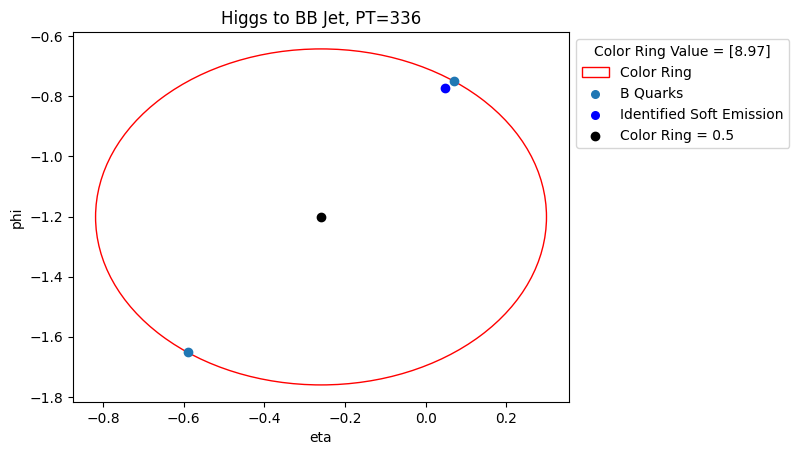

In [571]:
fig,ax = plt.subplots()
#ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label=f"H pT={higgs.pt}"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.scatter(higgs.children.eta, higgs.children.phi, 
           #s=higgs.children.pt, 
           label="B Quarks")
#ax.scatter(higgs.children[0].children.eta, higgs.children[0].children.phi, s=higgs.children[0].children.pt, marker="x", label="Child 0 children")
#ax.scatter(higgs.children[1].children.eta, higgs.children[1].children.phi, s=higgs.children[1].children.pt, marker="x", label="Child 1 children")
ax.scatter(largest_eta, largest_phi, 
           #s=largest_pt, 
           marker="o", color='b', label='Identified Soft Emission')
ax.scatter(midpoint_eta, midpoint_phi, label='Color Ring = 0.5', color='k')
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(uf_cr[cr_index]))
lgnd.legend_handles[1]._sizes = [30]
lgnd.legend_handles[2]._sizes = [30]
#lgnd.legend_handles[4]._sizes = [30]
#lgnd.legend_handles[5]._sizes = [30]
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Higgs to BB Jet, PT=336')